## Визуализация топологии жанров по MIR-баровым признакам


In [1]:
import os
import sys
import glob
from pathlib import Path

# Определение корня проекта для работы напрямую из ноутбука (VS Code, JupyterLab)
# Метод 1: Через IPython (работает в Jupyter/JupyterLab)
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        notebook_name = ipython.user_ns.get('__vsc_ipynb_file__') or ipython.user_ns.get('__file__')
        if notebook_name:
            notebook_path = Path(notebook_name).resolve()
            if 'notebooks' in str(notebook_path):
                project_root = notebook_path.parent.parent
            else:
                project_root = notebook_path.parent
        else:
            cwd = Path.cwd().resolve()
            if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
                project_root = cwd
            elif 'notebooks' in str(cwd):
                project_root = cwd.parent
            else:
                project_root = cwd
    else:
        raise AttributeError("Not in IPython")
except:
    # Метод 2: Через текущую рабочую директорию и поиск структуры проекта
    cwd = Path.cwd().resolve()
    if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
        project_root = cwd
    elif 'notebooks' in str(cwd):
        project_root = cwd.parent
    else:
        # Пробуем найти корень проекта, поднимаясь вверх
        current = cwd
        while current != current.parent:
            if (current / 'notebooks').exists() and (current / 'src').exists():
                project_root = current
                break
            current = current.parent
        else:
            project_root = cwd

# Добавляем корневую директорию проекта и src/ в путь
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

# Выводим информацию для отладки (можно закомментировать)
# Проверка и вывод информации
print(f"✓ Корень проекта: {project_root}")
print(f"✓ Путь к src: {project_root / 'src'}")
print(f"✓ Текущая рабочая директория: {Path.cwd()}")

# Дополнительная проверка структуры проекта
if (project_root / 'notebooks').exists() and (project_root / 'src').exists():
    print(f"✓ Структура проекта найдена корректно")
else:
    print(f"⚠ ВНИМАНИЕ: Структура проекта не найдена!")
    print(f"  Проверьте, что папки 'notebooks' и 'src' существуют в {project_root}")

import numpy as np
import matplotlib.pyplot as plt

from src.mir_bar_features import mir_bar_embeddings
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 120


✓ Корень проекта: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork
✓ Путь к src: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/src
✓ Текущая рабочая директория: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/notebooks
✓ Структура проекта найдена корректно


In [2]:
# Папка с жанровыми подкаталогами (от корня репозитория)
# Используем project_root для надежности работы из любой директории
base_genre_dir = str(project_root / "data/top50musicSpotify")

# Параметры MIR-баровых признаков
beats_per_bar = 4
use_auto_tempo = True
bpm = None

# Параметры t-SNE
tsne_perplexity = 50
tsne_iterations = 1000

# Параметры HDBSCAN
min_cluster_size = 20
min_samples = 5


In [4]:
def tsne_hdbscan_for_genre_mir(genre_dir: str):
    """Строит t-SNE и HDBSCAN-кластеры по MIR-баровым признакам для жанра."""
    audio_files = []
    audio_files.extend(glob.glob(os.path.join(genre_dir, "*.wav")))
    audio_files.extend(glob.glob(os.path.join(genre_dir, "*.mp3")))

    if not audio_files:
        print(f"Нет аудиофайлов в {genre_dir}")
        return

    all_bars = []

    for fpath in audio_files:
        try:
            bars = mir_bar_embeddings(
                file_path=fpath,
                beats_per_bar=beats_per_bar,
                use_auto_tempo=use_auto_tempo,
                bpm=bpm,
            )
            if bars.size == 0:
                continue
            all_bars.append(bars)
        except Exception as e:
            print(f"Ошибка при обработке {fpath}: {e}")

    if not all_bars:
        print(f"Не удалось получить MIR-признаки для {genre_dir}")
        return

    X = np.vstack(all_bars).astype(np.float32)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # t-SNE (по стандартизированным признакам)
    n_samples = X_scaled.shape[0]
    perplexity = min(tsne_perplexity, max(5, n_samples - 1))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=tsne_iterations,
        random_state=42,
        verbose=0,
    )
    X_2d = tsne.fit_transform(X_scaled)

    # HDBSCAN также работает поверх стандартизированного пространства
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
    )
    labels = clusterer.fit_predict(X_scaled)
    unique_labels = np.unique(labels)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Голый t-SNE
    axes[0].scatter(X_2d[:, 0], X_2d[:, 1], s=8, alpha=0.7, color="tab:blue")
    axes[0].set_title("t-SNE (MIR-баровые признаки)")
    axes[0].set_xlabel("t-SNE 1")
    axes[0].set_ylabel("t-SNE 2")
    axes[0].grid(alpha=0.3)

    # 2. t-SNE + HDBSCAN
    cmap = plt.get_cmap("tab20")
    for lab in unique_labels:
        mask = labels == lab
        if lab == -1:
            color = "lightgray"
            label = "шум (-1)"
        else:
            color = cmap(lab % 20)
            label = f"кластер {lab}"
        axes[1].scatter(X_2d[mask, 0], X_2d[mask, 1], s=8, alpha=0.8, color=color, label=label)

    axes[1].set_title("t-SNE + HDBSCAN (MIR)")
    axes[1].set_xlabel("t-SNE 1")
    axes[1].set_ylabel("t-SNE 2")
    axes[1].grid(alpha=0.3)
    if len(unique_labels) <= 20:
        axes[1].legend(fontsize=8)

    fig.suptitle(f"Жанр: {os.path.basename(genre_dir)} — MIR-баровые признаки", fontsize=14)
    plt.tight_layout()
    plt.show()


In [5]:
# Карта жанр → путь для отдельных запусков
if not os.path.exists(base_genre_dir):
    raise FileNotFoundError(f"Базовая папка с жанрами не найдена: {base_genre_dir}")

GENRE_PATHS = {
    name: os.path.join(base_genre_dir, name)
    for name in sorted(os.listdir(base_genre_dir))
    if os.path.isdir(os.path.join(base_genre_dir, name))
}

print("Доступные жанры:", ", ".join(GENRE_PATHS.keys()))


Доступные жанры: blues, classical, country, electronic, hip-hop, jazz, metal, pop, reggae, rock


### Blues


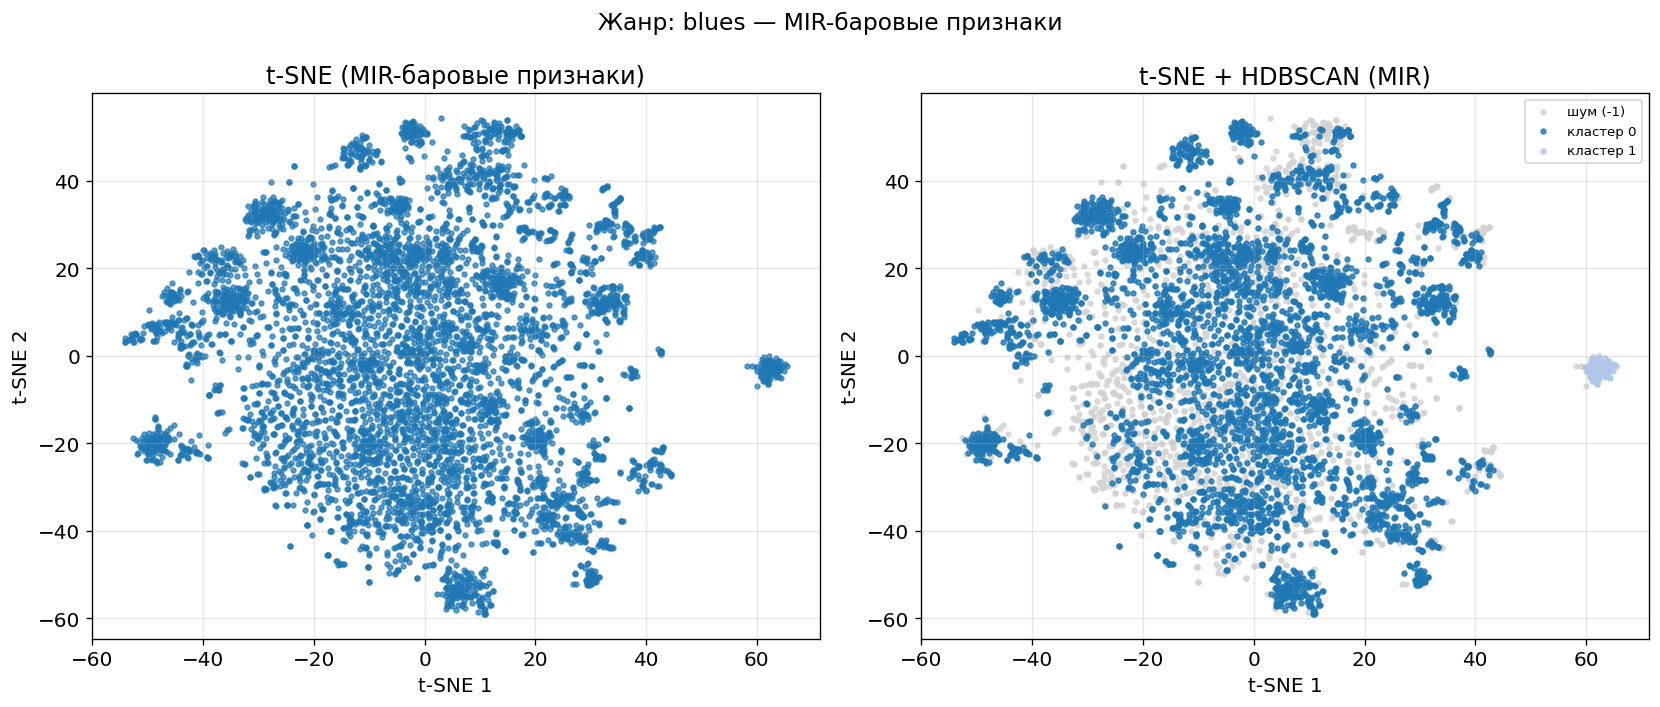

In [6]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["blues"])


### Classical


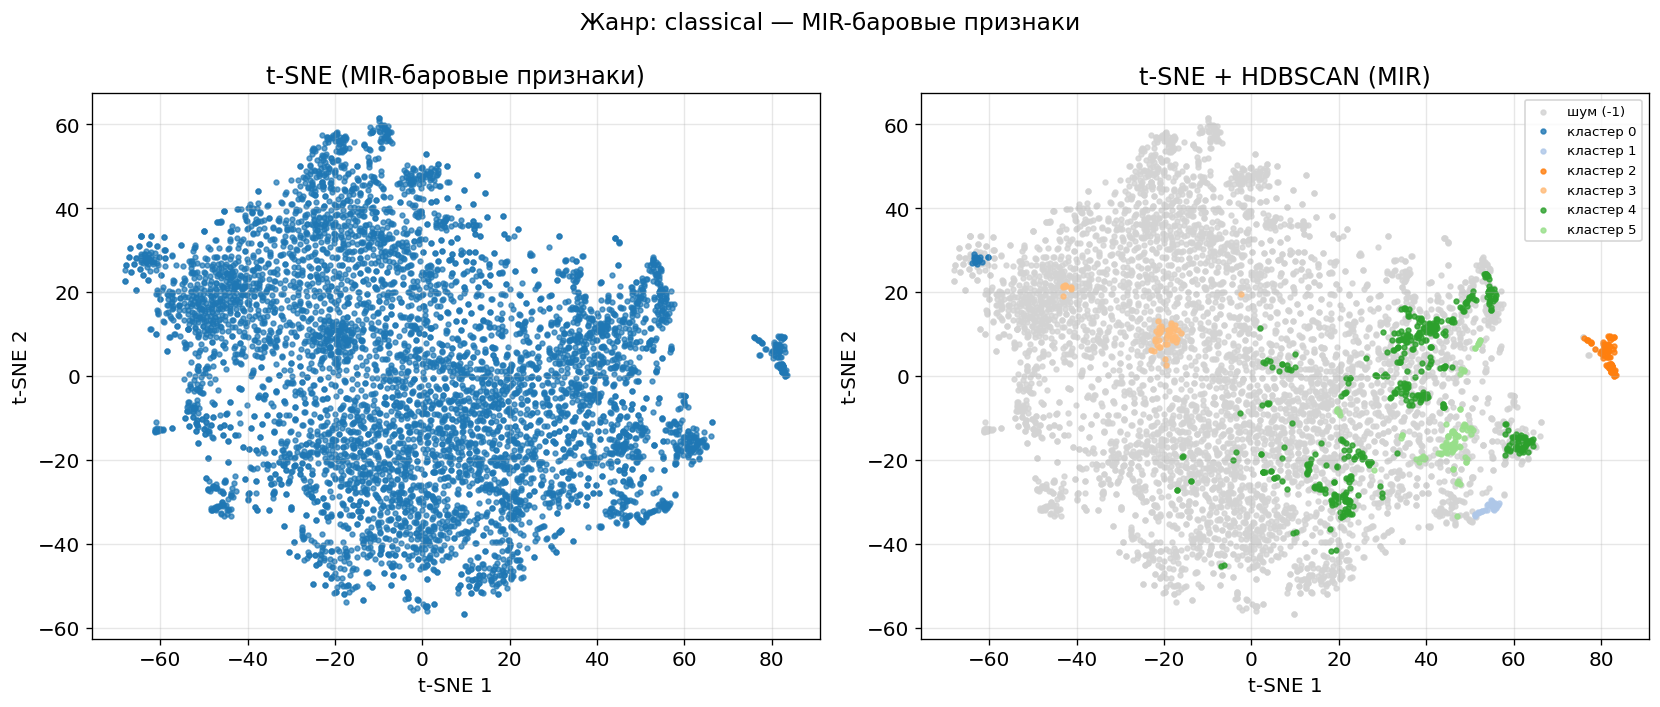

In [17]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["classical"])


### Country


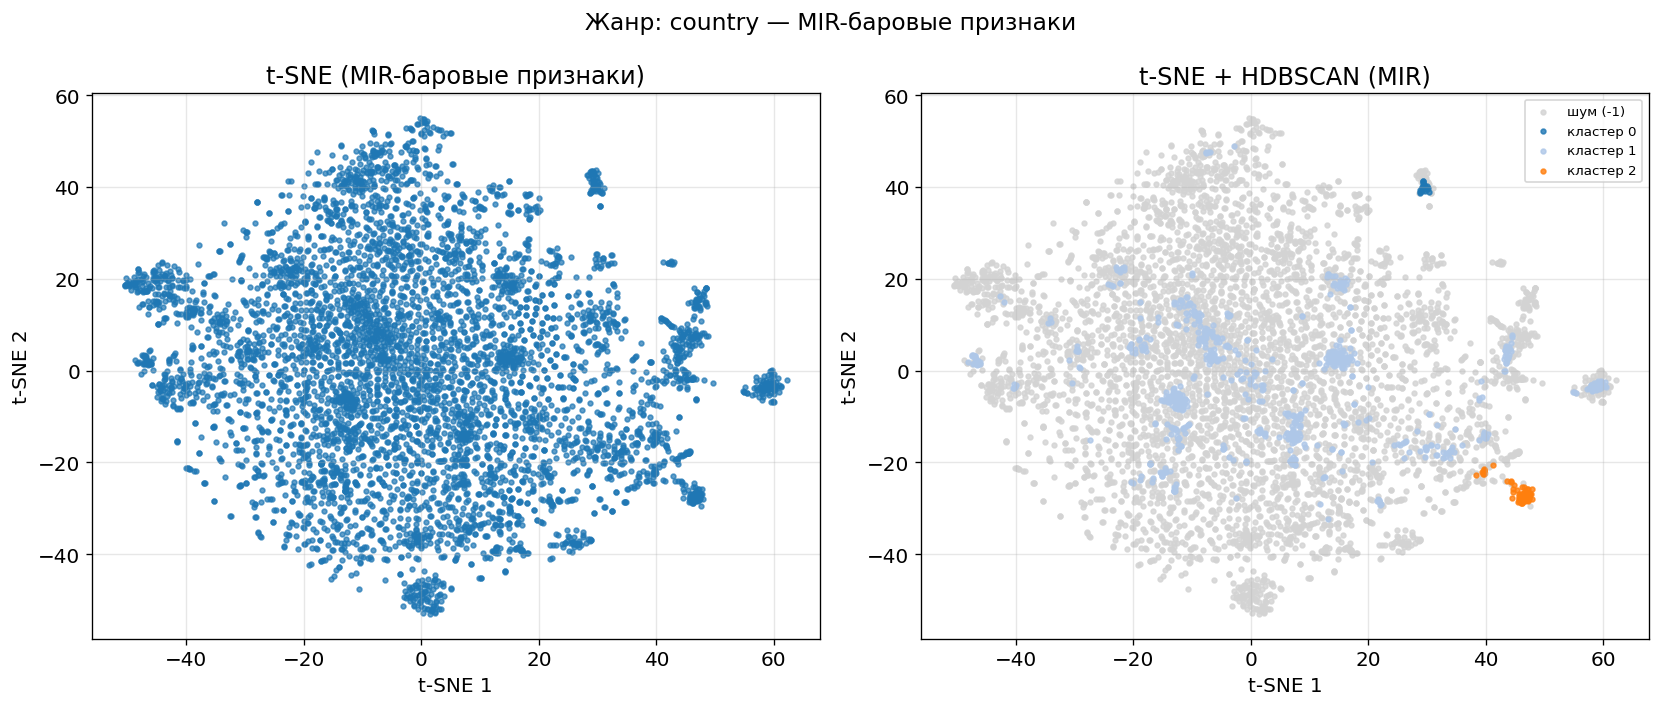

In [23]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["country"])


### Electronic


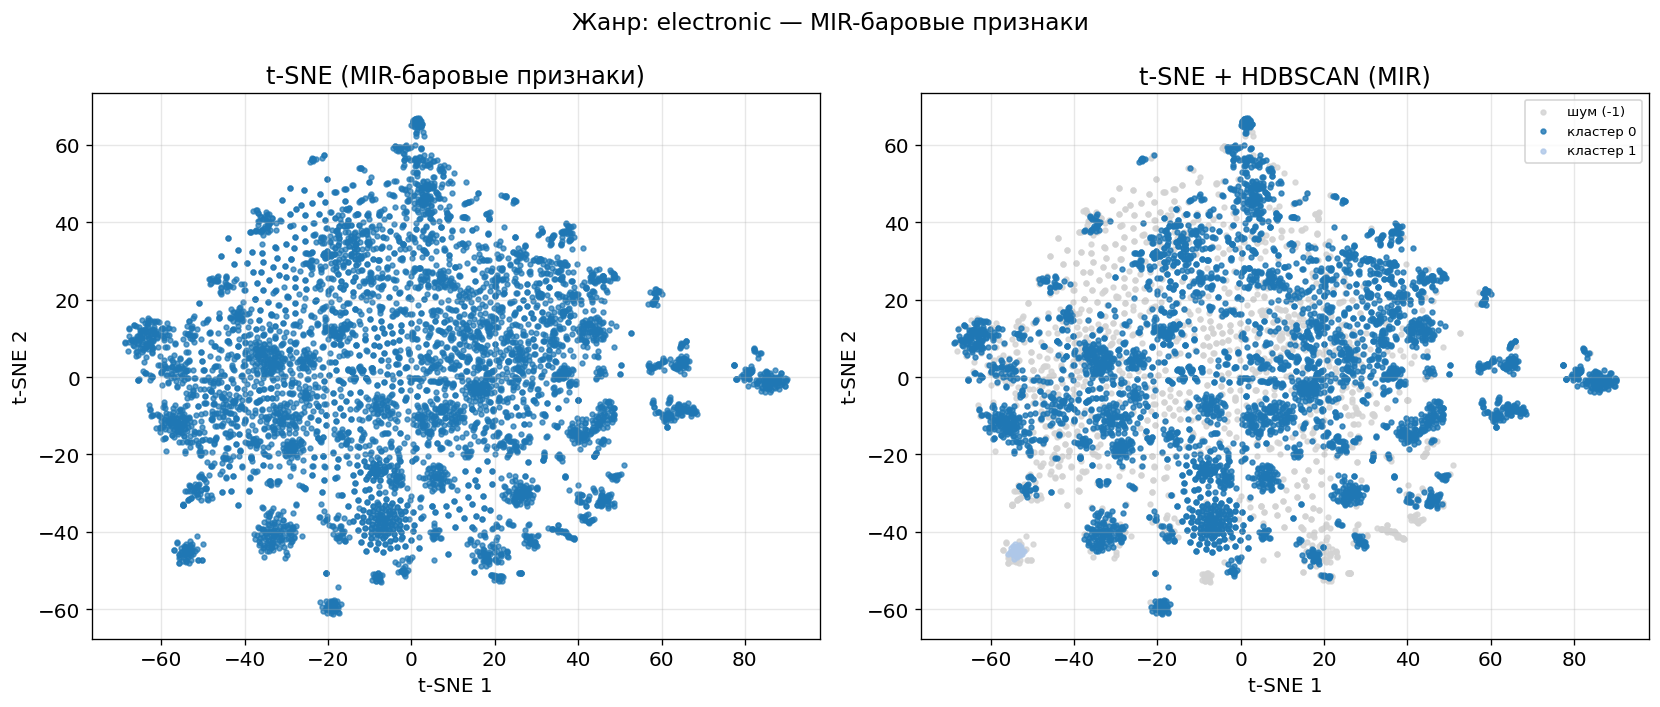

In [24]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["electronic"])


### Hip-hop


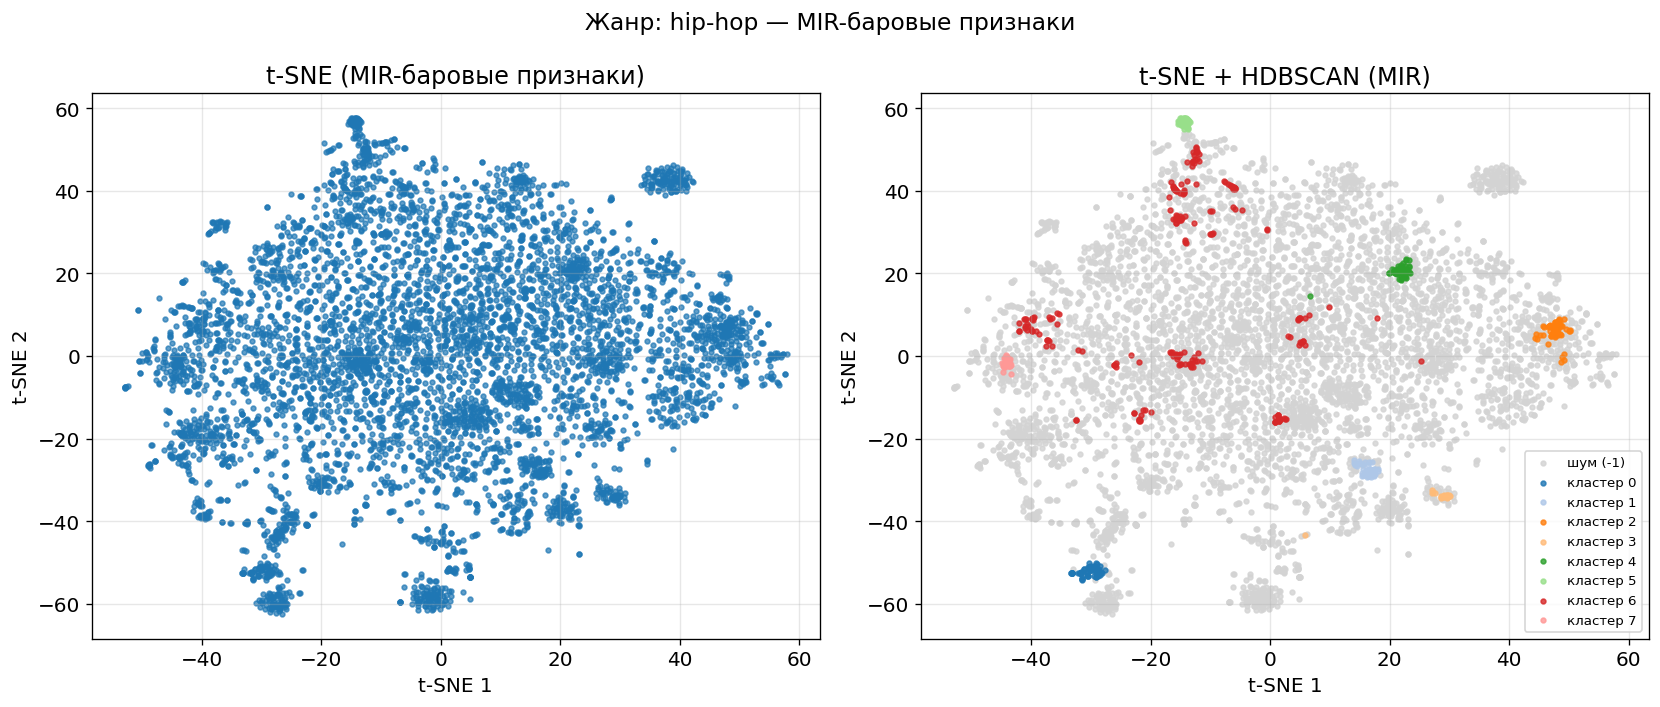

In [25]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["hip-hop"])


### Jazz


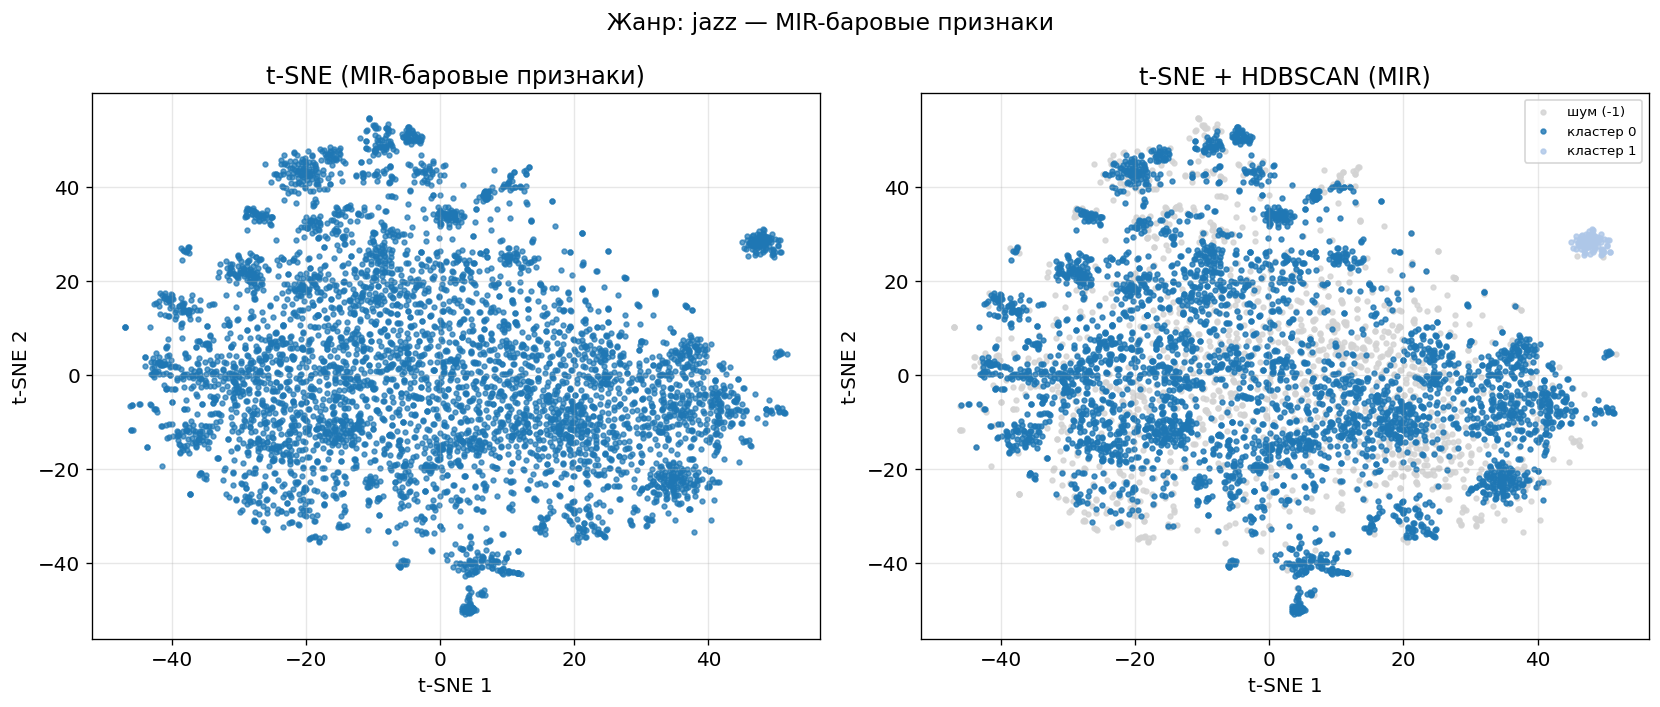

In [26]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["jazz"])


### Metal


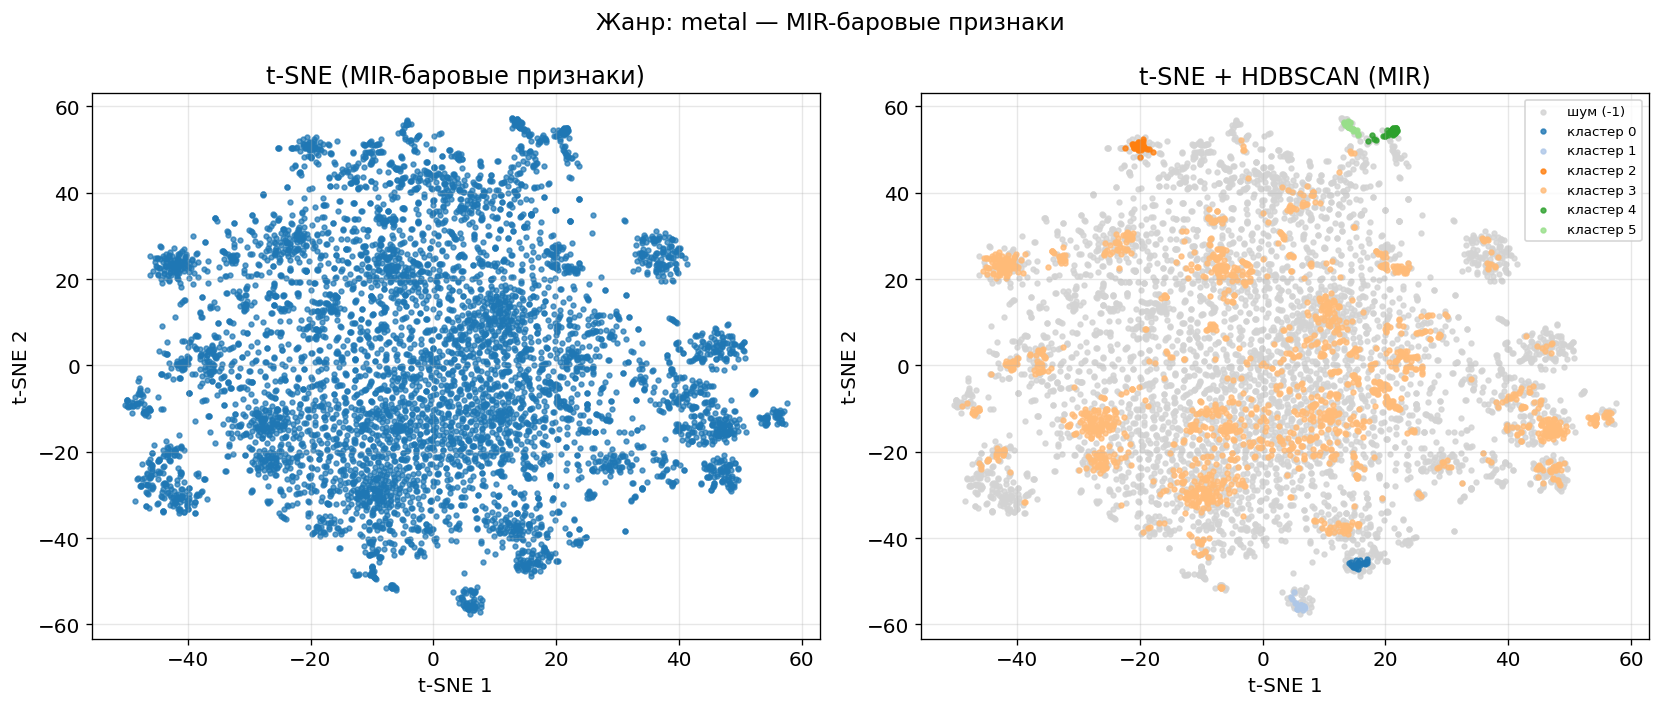

In [27]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["metal"])


### Pop


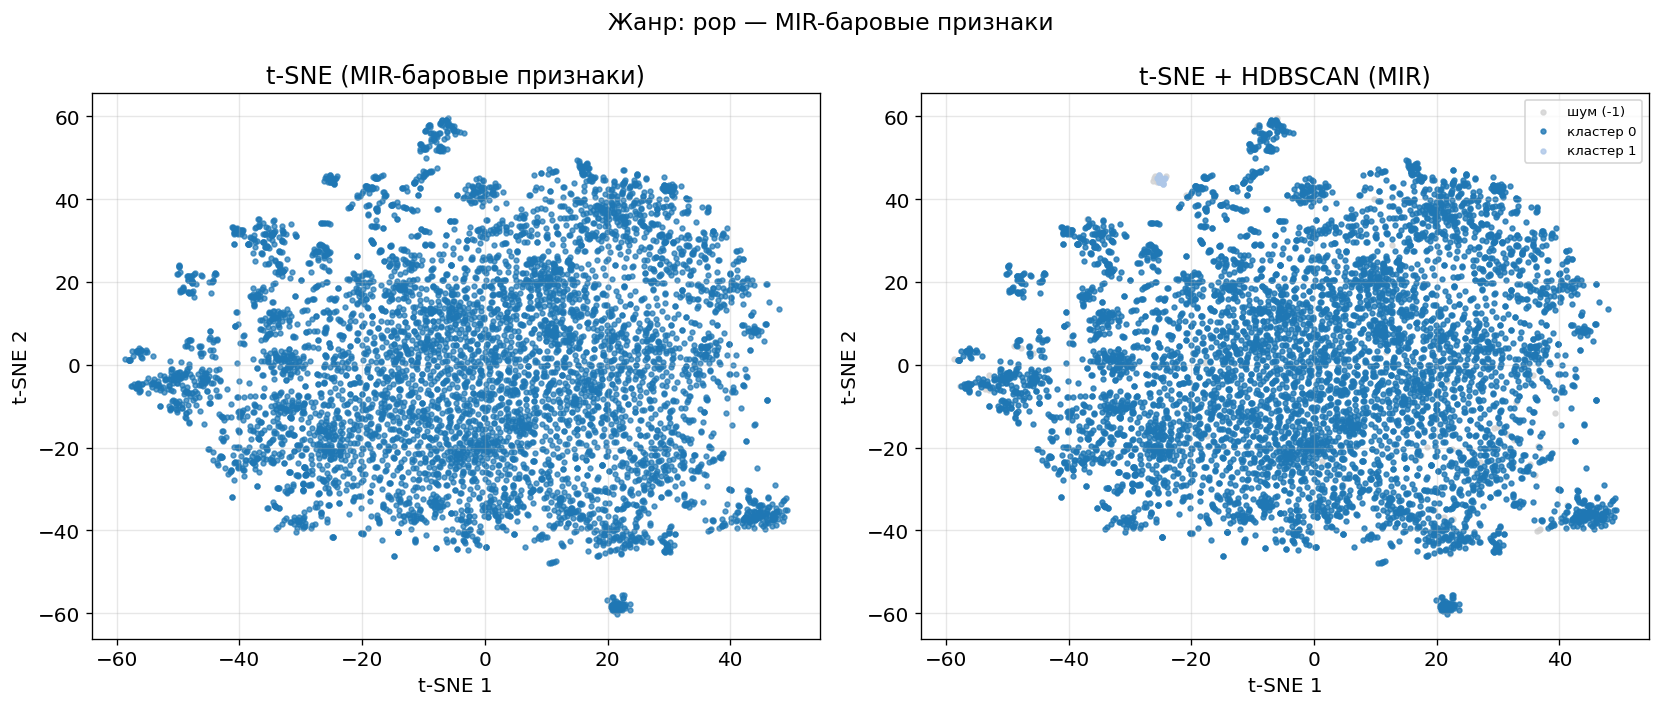

In [28]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["pop"])


### Reggae


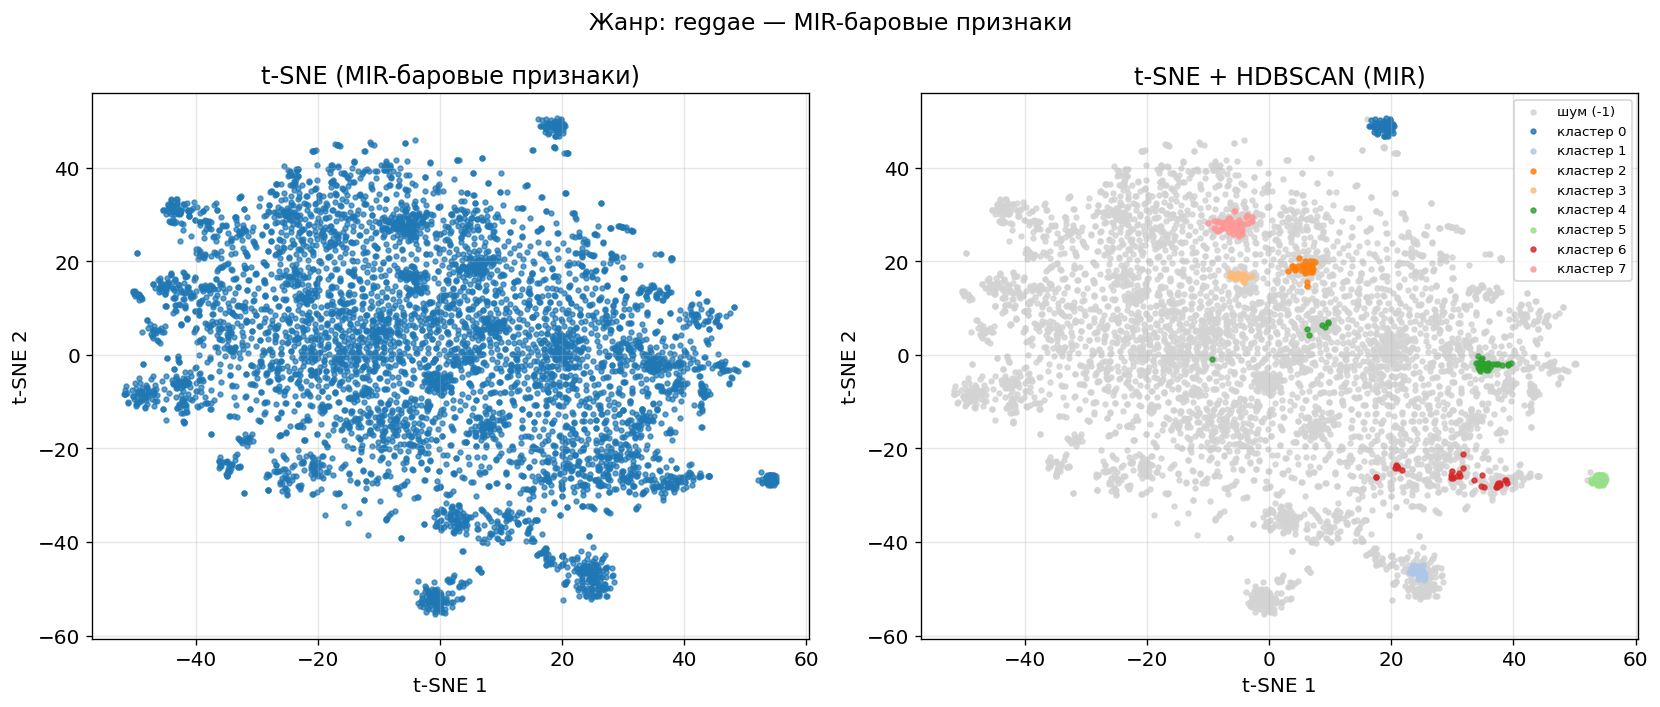

In [29]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["reggae"])


### Rock


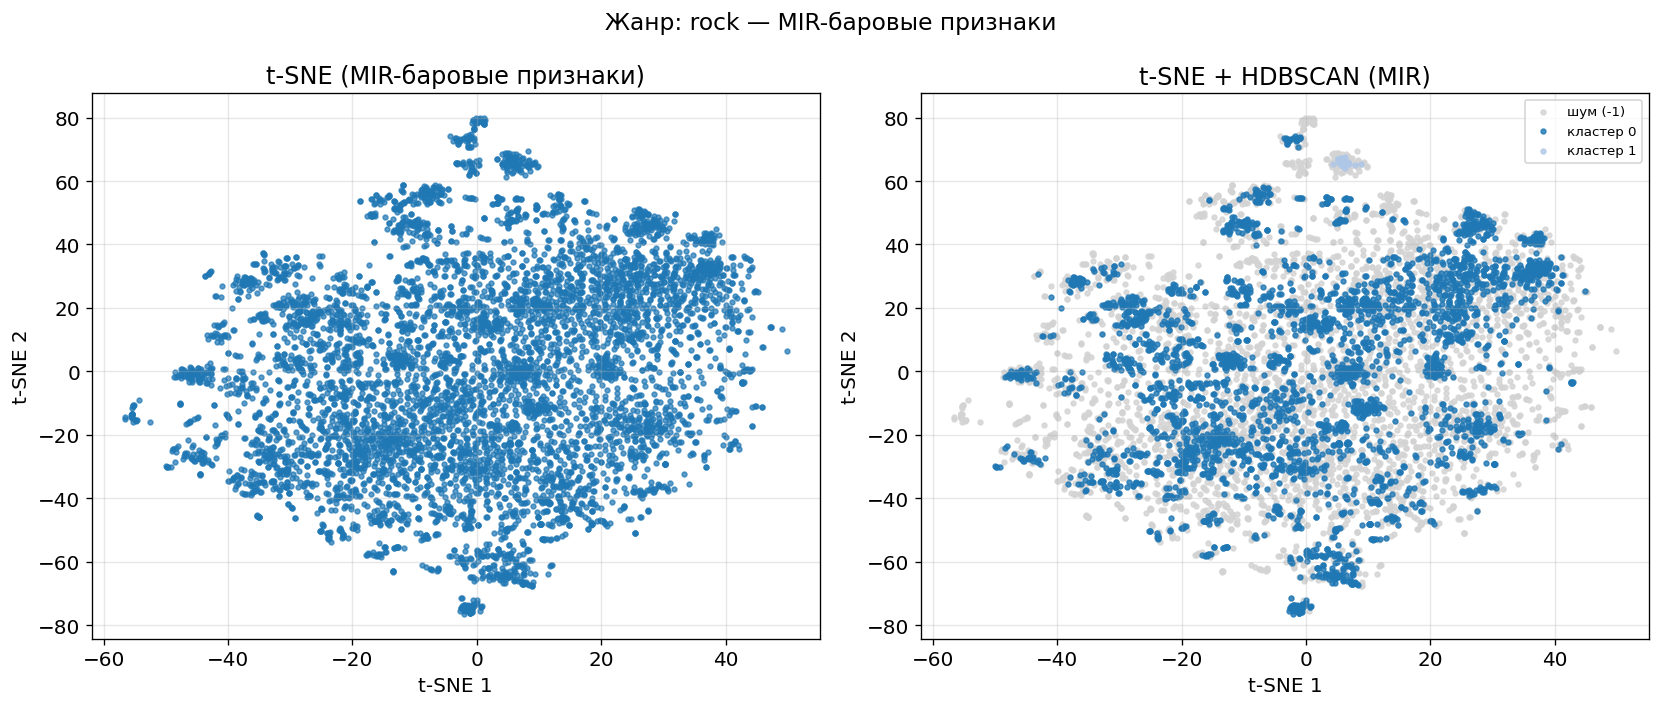

In [30]:
tsne_hdbscan_for_genre_mir(GENRE_PATHS["rock"])
